<a href="https://colab.research.google.com/github/ynadge/Music-Generation/blob/main/Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!sudo apt install -y fluidsynth  # FluidSynth is a real-time software synthesizer
!pip install --upgrade pyfluidsynth  # Contains python buildings for FluidSynth.
!pip install pretty_midi  # Library which handle MIDI data easily. Methods for parsing, modifying, and analyzing MIDI files.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [22]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [23]:
seed = 8
tf.random.set_seed(seed)  # Set tf's seed to 8.
np.random.seed(seed)
_SAMPLING_RATE = 16000  # Sampling rate for the audio playback. A sampling rate of 16 kHz means that the maximum frequency of the sampled audio signal is 8 kHz.

In [24]:
tf.keras.utils.get_file(  # Downloads a file from a URL if it not already in the cache.
    # keras is an API specification that describes how a Deep Learning framework should implement certain part, related to the model definition and training.
    # tf.keras is the Tensorflow specific implementation of the Keras API specification. It adds the framework the support for many Tensorflow specific features
    'maestro-v3.0.0-midi.zip',  # Download as
    origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',  # URL for data set.
    extract=True,
    cache_dir='.', cache_subdir='data',
)
data_dir = pathlib.Path('data/maestro-v3.0.0')  # Grabbing data from the given location.

In [25]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
# The "**" means "all folders and subfolders are to be counted". "*.mid*" gives the condition that "all folders and subfolders WITH .mid are to be counted."
print("Number of files: ", len(filenames))

Number of files:  1276


In [26]:
sample_file = filenames[9]  # Sampling a file
print(sample_file)

data/maestro-v3.0.0/2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--1.midi


In [27]:
pm = pretty_midi.PrettyMIDI(sample_file)  # Loading in the sample file using pretty_midi.

In [28]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds = 30):  # Function to play 30 seconds of the MIDI sample.
  waveform = pm.fluidsynth(fs = _SAMPLING_RATE)
  waveform_short = waveform[:seconds * _SAMPLING_RATE]
  return display.Audio(waveform_short, rate = _SAMPLING_RATE)

In [29]:
display_audio(pm)

In [30]:
def midi_to_notes(midi_file: str) ->pd.DataFrame:  # Passing a MIDI file as a string to the function and receiving 2D, size-mutable, potentially heterogeneous tabular data.
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]  # MIDI instrument 0 is part of the class Piano: Acoustic Grand Piano.
  # One of the most important functions of the PrettyMIDI class is to hold a list of Instrument class instances.
  # Each Instrument is able to store different events (for example, notes) which are meant to be played on a given general MIDI instrument (for example, instrument 42, "Cello").
  notes = collections.defaultdict(list)  # Group a sequence of key-value pairs into a dictionary of lists: [(key, [value, value]),...] type structure.
  sorted_notes = sorted(instrument.notes, key = lambda note: note.start)  # Creating a list of sorted notes from the MIDI instrument.
  # sorted(iterable = the structure to sort, key = lambda function that sets the parameter value, reverse = none)
  prev_start = sorted_notes[0].start  # Setting prev_start as the first one.

  for note in sorted_notes:  # Appending values to the notes dictionary of lists.
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})  # Creating a dataframe container from the dictionary of lists.

In [31]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()  # Shows the first couple values in the container.

,pitch,start,end,step,duration
0,50,0.936198,2.481771,0.000000,1.545573
1,38,0.941406,2.480469,0.005208,1.539062
2,62,1.298177,1.365885,0.356771,0.067708
3,64,1.401042,1.509115,0.102865,0.108073
4,66,1.501302,1.613281,0.100260,0.111979


In [32]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):  # We can provide a value for "count" if we like but the function can proceed without it too.
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])  # Number of notes can also be gathered form the size of the "pitch" list.
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

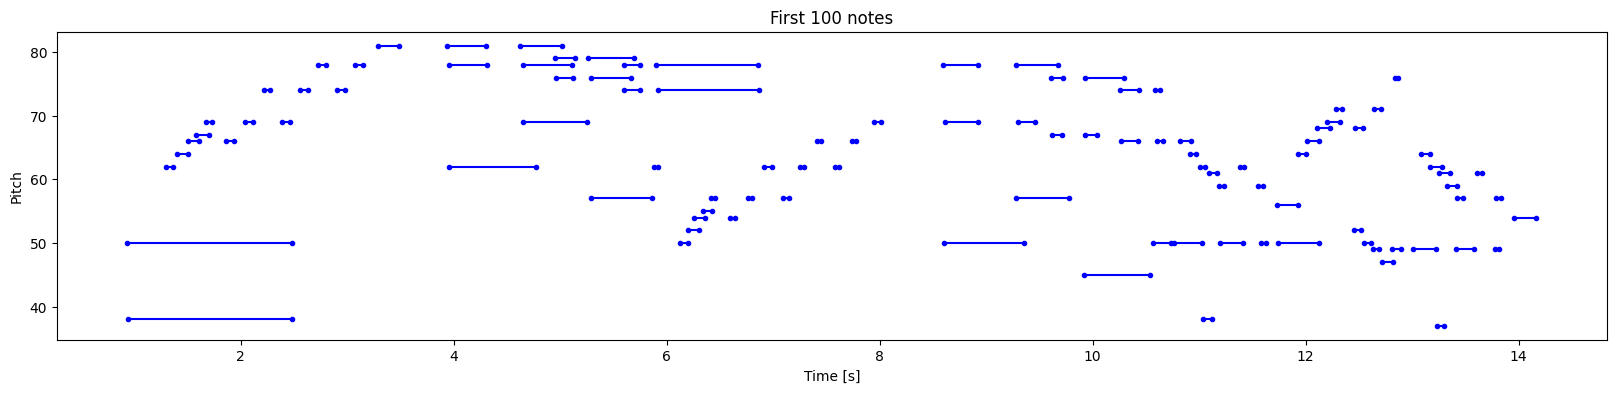

In [33]:
plot_piano_roll(raw_notes, count = 100)

In [34]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [35]:
example_file = "example.midi"
example_pm = notes_to_midi(
    raw_notes, out_file = example_file, instrument_name = "Acoustic Grand Piano"
)
display_audio(example_pm)

In [36]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)
all_notes = pd.concat(all_notes)

In [41]:
n_notes = len(all_notes)

In [37]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis = 1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [38]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [39]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [42]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [43]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [44]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [45]:
losses = model.evaluate(train_ds, return_dict=True)
losses

491/491 [==============================] - 9s 3ms/step - loss: 5.1304 - duration_loss: 0.1658 - pitch_loss: 4.8489 - step_loss: 0.1156


{'loss': 5.130381107330322,
 'duration_loss': 0.16583575308322906,
 'pitch_loss': 4.848942756652832,
 'step_loss': 0.1156020537018776}

In [46]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [47]:
model.evaluate(train_ds, return_dict=True)

491/491 [==============================] - 2s 3ms/step - loss: 0.5239 - duration_loss: 0.1658 - pitch_loss: 4.8489 - step_loss: 0.1156


{'loss': 0.523885190486908,
 'duration_loss': 0.16583575308322906,
 'pitch_loss': 4.848942756652832,
 'step_loss': 0.1156020537018776}

In [48]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [49]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
491/491 [==============================] - 7s 5ms/step - loss: 0.4111 - duration_loss: 0.1014 - pitch_loss: 4.0840 - step_loss: 0.1055
Epoch 2/50
491/491 [==============================] - 2s 5ms/step - loss: 0.4007 - duration_loss: 0.0975 - pitch_loss: 3.9570 - step_loss: 0.1053
Epoch 3/50
491/491 [==============================] - 2s 5ms/step - loss: 0.3979 - duration_loss: 0.0966 - pitch_loss: 3.9456 - step_loss: 0.1040
Epoch 4/50
491/491 [==============================] - 2s 5ms/step - loss: 0.3944 - duration_loss: 0.0959 - pitch_loss: 3.9216 - step_loss: 0.1024
Epoch 5/50
491/491 [==============================] - 3s 5ms/step - loss: 0.3905 - duration_loss: 0.0949 - pitch_loss: 3.8603 - step_loss: 0.1026
Epoch 6/50
491/491 [==============================] - 3s 5ms/step - loss: 0.3828 - duration_loss: 0.0941 - pitch_loss: 3.8427 - step_loss: 0.0966
Epoch 7/50
491/491 [==============================] - 3s 5ms/step - loss: 0.3839 - duration_loss: 0.0930 - pitch_loss: 3.826

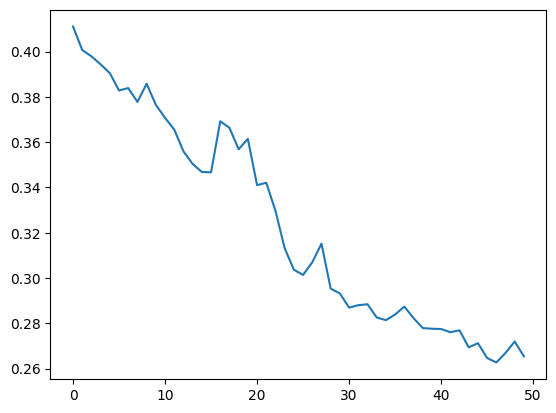

In [50]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [51]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [52]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 17ms/step


In [53]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name="Acoustic Grand Piano")
display_audio(out_pm)